In [1]:
!pip install tensorflow==2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # For y values
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()


In [3]:
np.random.seed(123)  # for reproducibility

## Some Helping Functions

In [4]:
def print_heatmap(data):
    heatmap = sns.heatmap(data)
    heatmap.set(xlabel='Pseudorapidity', ylabel='Azimuthal Angle')
    print(heatmap)
    #plt.imshow(data, cmap='jet', interpolation='nearest')
    #plt.show()

In [5]:
def get_predicted_values(output_values):
    predicted_values = []
    for probability in output_values:
        if probability[0] > probability[1]:
            predicted_values.append(0)
        else:
            predicted_values.append(1)
    return predicted_values

# Reading the data

First we read the Signal Data and produce a heatmap from the average of all lines. We do so, in order to get the feeling of what our data looks like.

In [6]:
! wget -c https://github.com/raphaelmcobe/jet-classification/raw/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt

--2020-02-19 16:28:26--  https://github.com/raphaelmcobe/jet-classification/raw/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo github.com (github.com)... 18.231.5.6
Conectando-se a github.com (github.com)|18.231.5.6|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 302 Found
Localização: https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt [redirecionando]
--2020-02-19 16:28:26--  https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.252.133
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|151.101.252.133|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 416 Range Not Satisfiable

    O arquivo já foi completamente obtido; não há nada a ser feito.



In [7]:
!ls -lh

total 536M
-rw-rw-r-- 1 hub hub  10M fev  6 15:29 '[Aapo_Hyvarinen,_Juha_Karhunen,_Erkki_Oja]_Indepen(z-lib.org).pdf'
-rw-r--r-- 1 hub hub  88M fev 19 16:06  background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
-rw-rw-r-- 1 hub hub 4,6M fev  6 15:29 '[Christopher_M._Bishop]_Pattern_Recognition_and_Ma(z-lib.org).pdf'
-rw-rw-r-- 1 hub hub  61M fev 13 14:37  google-chrome-stable_current_amd64.deb
-rw-rw-r-- 1 hub hub 112K fev 19 16:11 'Image_Jet_Tagging_Analysis_(PTJ_250_300).ipynb'
-rw-rw-r-- 1 hub hub 1,8M fev 14 11:10 'MODELO_PLANO_AUTOMAÇÃO 16,12% EaD IN2018(1).pdf'
-rw-rw-r-- 1 hub hub 341K fev 14 11:13 'MODELO_PLANO_AUTOMAÇÃO 16,12% EaD IN2018.odg'
-rw-rw-r-- 1 hub hub 1,8M fev 14 11:07 'MODELO_PLANO_AUTOMAÇÃO 16,12% EaD IN2018.pdf'
-rw-rw-r-- 1 hub hub  38M fev 14 17:27  OneDrive_1_14-02-2020.zip
-rw-r--r-- 1 hub hub  88M fev 19 15:57  signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
-rw-rw-r-- 1 hub hub 113M fev 13 16:11 'Todos os alunos SESI e SENAI - SGE.xlsx'
-rw-rw-r-- 1 hub hub  64

In [8]:
signal_data = pd.read_table('signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', header=None)
print(signal_data.shape)
print(signal_data.iloc[1:10,625])

(11298, 626)
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: 625, dtype: float64


As seen, the data read has a last column (no. 626) without data. This happens because the data read has trailing spaces. We need to remove such data.

In [9]:
signal_data.drop(625, axis=1, inplace=True)
print(signal_data.shape)

(11298, 625)


Then, we calculate the average of all observations.

In [10]:
mean_signal = signal_data.mean()
print(mean_signal.iloc[1:10,])

1    0.000000e+00
2    0.000000e+00
3    0.000000e+00
4    0.000000e+00
5    2.397279e-08
6    0.000000e+00
7    6.124087e-08
8    0.000000e+00
9    3.770772e-06
dtype: float64


Now draw the Heatmap

(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


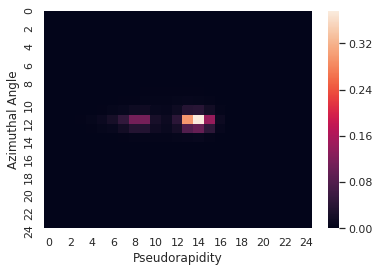

In [11]:
mean_signal_matrix = mean_signal.values
print(mean_signal_matrix.shape)
mean_signal_matrix = mean_signal_matrix.reshape((25,25))

print_heatmap(mean_signal_matrix)

We then add a last column, with the value of `1`. This last column classify this data as signal data. After creating the full dataset we will rename this column to _class_.

In [12]:
signal_data[625] = 1

In [13]:
signal_data.iloc[0:10,625]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: 625, dtype: int64

After preprocessing the _signal_ data, we will perform the same steps with the _background_ data.

In [14]:
!wget -c https://github.com/raphaelmcobe/jet-classification/raw/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt

--2020-02-19 16:28:29--  https://github.com/raphaelmcobe/jet-classification/raw/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo github.com (github.com)... 18.231.5.6
Conectando-se a github.com (github.com)|18.231.5.6|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 302 Found
Localização: https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt [redirecionando]
--2020-02-19 16:28:29--  https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.252.133
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|151.101.252.133|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 416 Range Not Satisfiable

    O arquivo já foi completamente obtido; não há nada a ser feito.



In [15]:
backgroud_data = pd.read_table('background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', header=None, dtype=np.float32)
print(backgroud_data.shape)

(11298, 626)


In [16]:
backgroud_data.drop(625, axis=1, inplace=True)
print(backgroud_data.shape)

(11298, 625)


In [17]:
mean_background = backgroud_data.mean()
print(mean_background.iloc[1:10,])

1    0.000000e+00
2    0.000000e+00
3    8.339239e-08
4    0.000000e+00
5    1.226879e-06
6    9.698673e-07
7    3.696426e-06
8    8.896710e-06
9    5.325904e-06
dtype: float32


(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


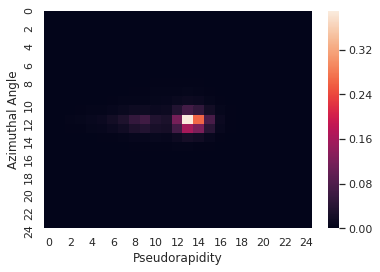

In [18]:
mean_background_matrix = mean_background.values
print(mean_background_matrix.shape)
mean_background_matrix = mean_background_matrix.reshape((25,25))

print_heatmap(mean_background_matrix)

We modify this data, to point out that this is the background data, by setting the last column to `0`.

In [19]:
backgroud_data[625] = 0

In [20]:
backgroud_data.iloc[0:10,625]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 625, dtype: int64

Now we concatenate the data and shuffle it in order to randomize its columns.

In [21]:
frames = [signal_data, backgroud_data]
full_data = pd.concat(frames)

In [22]:
full_data = full_data.sample(frac=1).reset_index(drop=True)
full_data.rename(columns={625:'class'}, inplace=True)

Now let's examine how our data looks like.

In [23]:
from IPython.core.display import display
with pd.option_context('display.max_rows', 200, 'display.max_columns', 15, 
                       'display.float_format', '{:.2f}'.format):
    display(full_data)

,0,1,2,3,4,5,6,...,619,620,621,622,623,624,class
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22591,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22592,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22593,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22594,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0


# Defining and Training the model

Split the full dataset into _test_ and _train_ data in a 70-30% rate.

In [298]:
train_data, test_data = train_test_split(full_data, test_size = 0.3)
print(train_data.shape)

print(test_data.shape)

(15817, 626)
(6779, 626)


The _Keras_ framework, in order to train its network must receive the dependent and independent variables in  separated tables.

In [299]:
X_train = train_data.iloc[:, :-1]
print(X_train.shape)
Y_train = train_data.iloc[:,-1:]
print(Y_train.shape)

(15817, 625)
(15817, 1)


In [300]:
X_test = test_data.iloc[:, :-1]
print(X_test.shape)
Y_test = test_data.iloc[:,-1:]
print(Y_test.shape)

(6779, 625)
(6779, 1)


We must convert the dependent variable to be a probability distribution of the possible outcomes, thus, a value of output `1` must become the probabilities `(0, 1)`. Conversely, a `0` outcome value must become the pair `(1, 0)`.

In [301]:
Y_train = to_categorical(Y_train.values, num_classes=2)

## Neural Network Architecture Definition

We defined a simple NN, with only two hidden layer.

In [302]:
dimof_input = X_train.shape[1]
model = Sequential()
model.add(Dense(units=8, activation='relu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=5, activation='elu', input_dim=dimof_input))
model.add(Dense(units=2))
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
              metrics=["accuracy"])

After defining the NN architecture we train it using the `fit` method. We trained it for 50 epochs (backpropagation cycles). 

In [303]:
model.fit(X_train.values, Y_train, batch_size=128, epochs=180, verbose=1)

Train on 15817 samples
Epoch 1/180
15817/15817 [==============================] - 1s 33us/sample - loss: 0.1430 - accuracy: 0.5615
Epoch 2/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.1053 - accuracy: 0.6743
Epoch 3/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0986 - accuracy: 0.6945
Epoch 4/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0953 - accuracy: 0.7067
Epoch 5/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0931 - accuracy: 0.7121
Epoch 6/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0910 - accuracy: 0.7188
Epoch 7/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0889 - accuracy: 0.7280
Epoch 8/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0878 - accuracy: 0.7330
Epoch 9/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0867 - accuracy: 0.7351
Epoch

15817/15817 [==============================] - 0s 16us/sample - loss: 0.0720 - accuracy: 0.7905
Epoch 77/180
15817/15817 [==============================] - 0s 17us/sample - loss: 0.0718 - accuracy: 0.7886
Epoch 78/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0710 - accuracy: 0.7914
Epoch 79/180
15817/15817 [==============================] - 0s 17us/sample - loss: 0.0713 - accuracy: 0.7937
Epoch 80/180
15817/15817 [==============================] - 0s 17us/sample - loss: 0.0714 - accuracy: 0.7929
Epoch 81/180
15817/15817 [==============================] - 0s 17us/sample - loss: 0.0715 - accuracy: 0.7898
Epoch 82/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0709 - accuracy: 0.7931
Epoch 83/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0708 - accuracy: 0.7939
Epoch 84/180
15817/15817 [==============================] - 0s 17us/sample - loss: 0.0714 - accuracy: 0.7924
Epoch 85/180
15817/15817 [======

15817/15817 [==============================] - 0s 17us/sample - loss: 0.0684 - accuracy: 0.8029
Epoch 151/180
15817/15817 [==============================] - 0s 17us/sample - loss: 0.0687 - accuracy: 0.8029
Epoch 152/180
15817/15817 [==============================] - 0s 17us/sample - loss: 0.0683 - accuracy: 0.8032
Epoch 153/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0688 - accuracy: 0.8021
Epoch 154/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0687 - accuracy: 0.7999
Epoch 155/180
15817/15817 [==============================] - 0s 18us/sample - loss: 0.0691 - accuracy: 0.8017
Epoch 156/180
15817/15817 [==============================] - 0s 17us/sample - loss: 0.0687 - accuracy: 0.7987
Epoch 157/180
15817/15817 [==============================] - 0s 17us/sample - loss: 0.0687 - accuracy: 0.7998
Epoch 158/180
15817/15817 [==============================] - 0s 16us/sample - loss: 0.0690 - accuracy: 0.8008
Epoch 159/180
15817/1581

After training the model we need to evaluate it.

In [244]:
Y_test = to_categorical(Y_test.values, num_classes=2)

In [245]:
score = model.evaluate(X_test.values, Y_test, verbose=0)
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.0819498682500409, 0.75350344]


Now let's take a look at the missclassified observations.

In [246]:
Y_test_predicted = model.predict(X_test.values, verbose=0)

In [247]:
Y_test_predicted

array([[ 0.66793203,  0.22345819],
       [ 0.8157691 ,  0.04680941],
       [ 0.94253874, -0.10236895],
       ...,
       [-0.09121418,  0.98655665],
       [ 0.5268257 ,  0.36084896],
       [ 0.580341  ,  0.23697324]], dtype=float32)

Now we calculate the false negatives and also the false positives by comparing the true value with the predicted one.

In [248]:
Y_test_predicted_values = get_predicted_values(Y_test_predicted)
Y_test_values = get_predicted_values(Y_test)
print(Y_test_predicted_values[1:10])
print(Y_test_values[1:10])

false_positives = []
false_negatives = []
for i in range(len(Y_test_values)):
    if Y_test_values[i] == 0 and Y_test_predicted_values[i] == 1:
        false_positives.append(i)
    elif Y_test_values[i] == 1 and Y_test_predicted_values[i] == 0:
        false_negatives.append(i)
        
print("False Positive Rate: {:.2f}".format(len(false_positives)/len(Y_test_values)))
print("False Negative Rate: {:.2f}".format(len(false_negatives)/len(Y_test_values)))

[0, 0, 0, 1, 0, 1, 1, 0, 0]
[0, 0, 0, 1, 1, 0, 1, 0, 1]
False Positive Rate: 0.12
False Negative Rate: 0.13


And try to visualize the heatmaps for false positives and negatives. Firstly the false negatives, where the network was supposed to answer _Signal_, but instead, it answered _Background_.

[17, 25, 45, 47, 68, 76, 87, 93, 97]
(825, 625)
(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


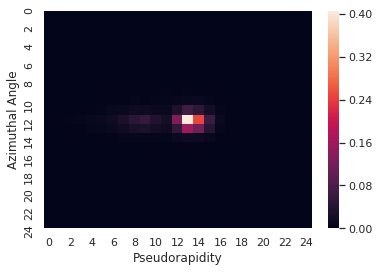

In [68]:
print(false_negatives[1:10])
false_negatives_values = X_test.iloc[false_negatives,]
print(false_negatives_values.shape)

mean_false_negatives = false_negatives_values.mean().values
print(mean_false_negatives.shape)
mean_false_negatives = mean_false_negatives.reshape((25,25))

print_heatmap(mean_false_negatives)

Then we examine the cases in which the network should have responded _Background_, but it answered _Signal_.

[19, 31, 36, 37, 48, 49, 51, 62, 63]
(878, 625)
(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


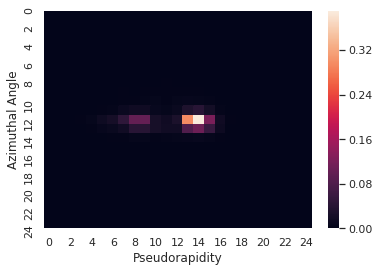

In [69]:
print(false_positives[1:10])
false_positives_values = X_test.iloc[false_positives,]
print(false_positives_values.shape)

mean_false_positives = false_positives_values.mean().values
print(mean_false_positives.shape)
mean_false_positives = mean_false_positives.reshape((25,25))

print_heatmap(mean_false_positives)